In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from sebm.data import setup_data_loader
from sebm.utils import load_models, init_models, plot_samples
from sebm.sgld import SGLD_Sampler

model_name = 'VERA'
data_dir = '../data/'
data = 'mnist'
device = 'cpu'
seed = 1

exp_name = "VERA_d={}_z=128_lrp=5e-05_lrq=0.0002_lrx=0.0002_gamma=0.1_lamb=1.0".format(data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
if data in ['mnist', 'fashionmnist']:
    lambda_ent = 1.0
    network_args = {'device': device,
                    'im_height': 28, 
                    'im_width': 28, 
                    'input_channels': 1, 
                    'channels': [32,32,64,64], 
                    'kernels': [3,4,4,4], 
                    'strides': [1,2,2,2], 
                    'paddings': [1,1,1,1],
                    'hidden_dims': [256],
                    'latent_dim': 128,
                    'activation': 'SiLU',
                    'xee_init_sigma': 0.1,
                    'gen_channels': [64,64,32,32,1], 
                    'gen_kernels': [4,4,3,4,4], 
                    'gen_strides': [1,2,2,2,2], 
                    'gen_paddings': [1,1,1,1,1],
                    'gen_activation': 'ReLU',
                   }
else:
    lambda_ent = 1.0
    network_args = {'device': device,
                    'im_height': 28, 
                    'im_width': 28, 
                    'input_channels': 1, 
                    'channels': [64,128,256,512],
                    'kernels': [3,4,4,4], 
                    'strides': [1,2,2,2], 
                    'paddings': [1,1,1,1],
                    'hidden_dims': [1024,256], 
                    'latent_dim': 128,
                    'activation': 'SiLU',
                    'dec_paddings': [1,1,0,0],
                    'xee_init_sigma': 0.1,
                    'gen_channels': [512,256,128,64,1], 
                    'gen_kernels': [4,4,3,4,4], 
                    'gen_strides': [1,2,2,2,2], 
                    'gen_paddings': [1,1,1,1,1],
                    'gen_activation': 'ReLU',
                   }

models = init_models(model_name, device, network_args)
load_models(models, exp_name,map_location=torch.device('cpu'))

In [3]:
# from sebm.eval import Evaluator
# evaluator = Evaluator(device, models, model_name, data)
# evaluator.few_label_classification(list_num_shots=[1], num_runs=1)

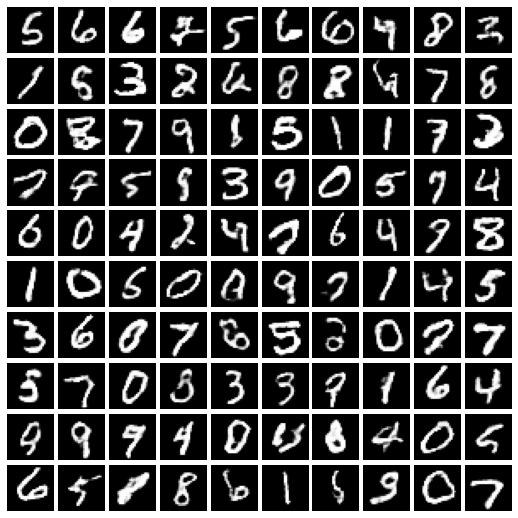

In [6]:
from sebm.utils import plot_samples
z, x, x_mu = models['gen'].sample(100)
plot_samples(x_mu, denormalize=True, fs=0.7)

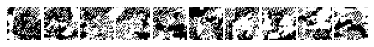

In [9]:
sgld_args = {'im_h': network_args['im_height'], 
             'im_w':  network_args['im_width'], 
             'im_channels':  network_args['input_channels'],
             'device': device,
             'alpha': 2.0,
             'noise_std': 5e-3,
             'buffer_size': 1,
             'reuse_freq': 1}
sgld_sampler = SGLD_Sampler(**sgld_args)

images_ebm = sgld_sampler.sample(models['cebm'].energy, 
                                 batch_size=10, 
                                 num_steps=500,
                                 pcd=False)
plot_samples(images_ebm, denormalize=True, save_name=None)#'{}_fg'.format(sample_name))  

In [ ]:
import hamiltorch
import matplotlib.pyplot as plt
from cebm.data import setup_data_loader
from tqdm import tqdm

num_hmc_steps = 500
step_size = 1e-3
num_leapfrog_steps = 10
batch_size = 1

dataset_args = {'data': data, 
                'data_dir': '../datasets/', 
                'num_shots': -1,
                'batch_size': batch_size,
                'train': False, 
                'normalize': True}
test_loader, _, _, _ = setup_data_loader(**dataset_args)
for b, (imgs, labels) in enumerate(test_loader):
    imgs = imgs.to(device)
    E_data = models['ebm'].energy(imgs)
#     z_mu, z_sigma = models['ebm'].latent_params(imgs)
    break
    
# z_mu = z_mu.detach()

x_data = imgs[0][None]
v_data = torch.atanh(x_data).flatten().to(device)
# # initialize a variable v \in [-inf ,inf] using atanh()
x_init = (torch.rand((1, 1, 28, 28)) - 0.5) / 0.5
v_init = torch.atanh(x_init).flatten().to(device)
# # v_init = torch.atanh(imgs[0][None]).flatten().to(device)
samples_noise = [x_init.cpu()]
samples_data = [x_data.cpu()]


# def log_prob(v_init):
#     nss1, nss2 = models['ebm'].forward(torch.tanh(v_init).reshape(1,1,28,28))
#     return ((nss1 * z_mu).sum(1) + (nss2 * (z_mu**2)).sum(1)).sum() 
    

def log_prob(v_init):
    return  -models['ebm'].energy(torch.tanh(v_init).reshape(1,1,28,28)).sum()

v_noise_final = hamiltorch.sample(log_prob, 
                            v_init, 
                            num_samples=num_hmc_steps, 
                            step_size=step_size, 
                            num_steps_per_sample=num_leapfrog_steps)    

v_data_final = hamiltorch.sample(log_prob, 
                            v_data, 
                            num_samples=num_hmc_steps, 
                            step_size=step_size, 
                            num_steps_per_sample=num_leapfrog_steps)    

In [ ]:
def compute_energy(v_final, samples):
    for v in v_final:
        x = torch.tanh(v.reshape(1,1,28,28))
        samples.append(x.cpu().detach())
    samples = torch.cat(samples, 0)   
    E_hmc = models['ebm'].energy(samples.to(device)).cpu().data.numpy()
    return samples, E_hmc

def plot_hmc(E_hmc, samples):
    fig = plt.figure(figsize=(3, 5))
    ax = fig.add_subplot(111)
    ax.plot(E_hmc, label='HMC')
    ax.set_ylabel('E(x)')
    ax.plot(torch.arange(len(E_hmc)), torch.ones(len(E_hmc)) * E_data[0].item(), label='E(x_data)')
    ax.legend()

    fs = 0.7
    fig = plt.figure(figsize=(fs, fs))
    ax = fig.add_subplot(111)
    ax.imshow(samples[0][0] * 0.5 + 0.5, cmap='gray', vmin=0.0, vmax=1.0)
    ax.set_xticks([])
    ax.set_yticks([])
    plot_samples(samples[-20:], denormalize=True, fs=fs)

In [ ]:
samples_data_final, E_hmc_data = compute_energy(v_data_final, samples_data)
samples_noise_final, E_hmc_noise = compute_energy(v_noise_final, samples_noise)

plot_hmc(E_hmc_data, samples_data_final)

In [ ]:
plot_hmc(E_hmc_noise, samples_noise_final)

In [ ]:
# from cebm.mala import MALA_Sampler
# num_steps = 100
# lr = 0.01
# batch_size = 10
# mala_sampler =  MALA_Sampl er(im_h=network_args['im_height'],
#                              im_w=network_args['im_width'],
#                              im_channels=network_args['input_channels'],
#                              device=device,
#                              batch_size=batch_size,
#                              latent_dim=network_args['latent_dim'])

# x_init, x_final = mala_sampler.refine_MALA(models, num_steps, lr)